In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.8 MB/s eta 0:00:00


In [2]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
# 1. Load Data
X_train = pd.read_csv('cleveland_X_train_processed.csv')
X_test = pd.read_csv('cleveland_X_test_processed.csv')
y_train = pd.read_csv('cleveland_y_train_processed.csv').values.ravel()
y_test = pd.read_csv('cleveland_y_test_processed.csv').values.ravel()

In [4]:
# 2. Define Optuna Objective Function
def objective(trial):
    # Search space for n_estimators and random_state as requested
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    # Tuning random_state checks for the seed that works best with the data splits
    random_state = trial.suggest_int('random_state', 0, 100)

    # Initialize Random Forest with suggested parameters
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # 10-Fold Cross-Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # n_jobs=-1 uses all CPU cores
    scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)

    return scores.mean()

In [5]:
# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-12-04 08:02:24,030] A new study created in memory with name: no-name-a5b210d2-793b-43bb-87d9-fff0327eae54
[I 2025-12-04 08:02:40,926] Trial 0 finished with value: 0.8073593073593074 and parameters: {'n_estimators': 279, 'random_state': 29}. Best is trial 0 with value: 0.8073593073593074.
[I 2025-12-04 08:02:46,746] Trial 1 finished with value: 0.793073593073593 and parameters: {'n_estimators': 245, 'random_state': 92}. Best is trial 0 with value: 0.8073593073593074.
[I 2025-12-04 08:02:55,415] Trial 2 finished with value: 0.7930735930735929 and parameters: {'n_estimators': 215, 'random_state': 56}. Best is trial 0 with value: 0.8073593073593074.
[I 2025-12-04 08:02:57,870] Trial 3 finished with value: 0.7883116883116883 and parameters: {'n_estimators': 76, 'random_state': 45}. Best is trial 0 with value: 0.8073593073593074.
[I 2025-12-04 08:02:59,574] Trial 4 finished with value: 0.7930735930735932 and parameters: {'n_estimators': 45, 'random_state': 83}. Best is trial 0 with v

In [6]:
best_params = study.best_params
print(f"Best Parameters found: {best_params}")

Best Parameters found: {'n_estimators': 279, 'random_state': 29}


In [7]:
# 3. Retrain Model with Best Parameters
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    random_state=best_params['random_state']
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=279, random_state=29)

In [8]:
# 4. Evaluate on Training Data
y_train_pred = best_rf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

In [9]:
# 5. Evaluate on Test Data
y_test_pred = best_rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [10]:
# 6. Print Results
print("Training Set Metrics:")
print(f"  Accuracy:  {train_acc * 100:.2f}%")
print(f"  Precision: {train_prec * 100:.2f}%")
print(f"  Recall:    {train_rec * 100:.2f}%")
print(f"  F1 Score:  {train_f1 * 100:.2f}%")

print("Test Set Metrics:")
print(f"  Accuracy:  {test_acc * 100:.2f}%")
print(f"  Precision: {test_prec * 100:.2f}%")
print(f"  Recall:    {test_rec * 100:.2f}%")
print(f"  F1 Score:  {test_f1 * 100:.2f}%")

Training Set Metrics:
  Accuracy:  100.00%
  Precision: 100.00%
  Recall:    100.00%
  F1 Score:  100.00%
Test Set Metrics:
  Accuracy:  81.32%
  Precision: 80.95%
  Recall:    79.07%
  F1 Score:  80.00%


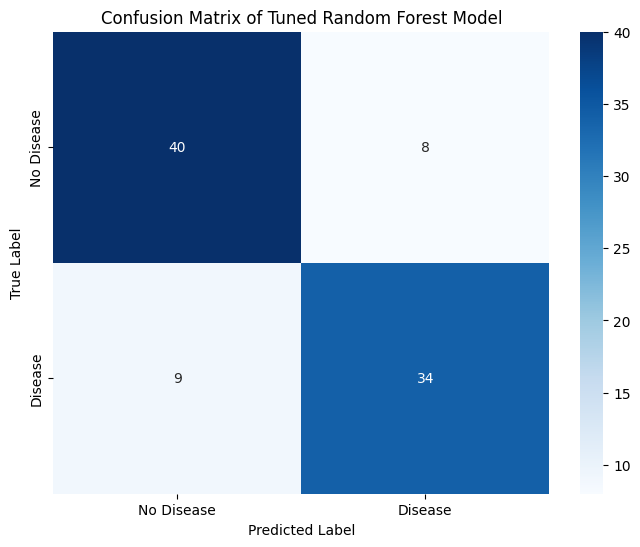

In [11]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Tuned Random Forest Model')
plt.show()

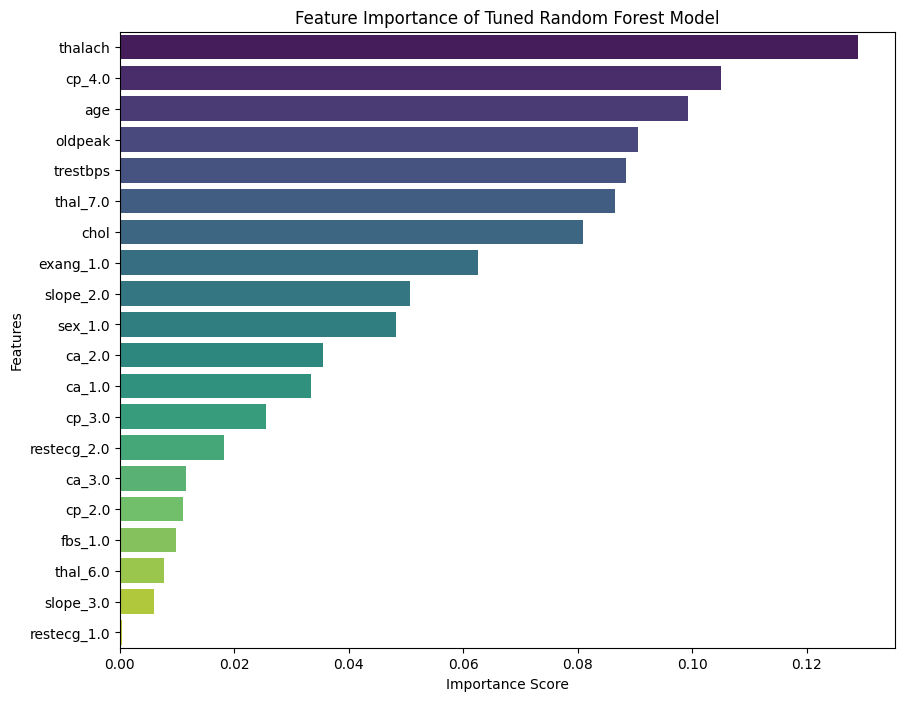

In [12]:
# 8. Visualization of Feature Importance
# Get importance from the trained model
importances = best_rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the Top Features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importance_df, palette='viridis', legend=False)
plt.title('Feature Importance of Tuned Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()